**cnn**

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
#from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

healthy_dirs = [
    r'/content/drive/MyDrive/Osteoporosis Knee X-ray/normal',
    r'/content/drive/MyDrive/normal/normal',
    r'/content/drive/MyDrive/Osteoporosis Knee Dataset/Normal',
    r'/content/drive/MyDrive/osteoporosis/normal'
]

osteoporosis_dirs = [
    r'/content/drive/MyDrive/Osteoporosis Knee X-ray/osteoporosis',
    r'/content/drive/MyDrive/osteoporosis/osteoporosis',
    r'/content/drive/MyDrive/Osteoporosis Knee Dataset/Osteoporosis',
    r'/content/drive/MyDrive/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                           filepaths   labels
0  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
1  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
2  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
3  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
4  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
labels
Osteoporosis    979
Healthy         780
Name: count, dtype: int64


In [ ]:
knee_osteoporosis_df.shape

(1759, 2)

In [ ]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1407, 2)
(528, 2)
(352, 2)
(1231, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1407 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 352 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

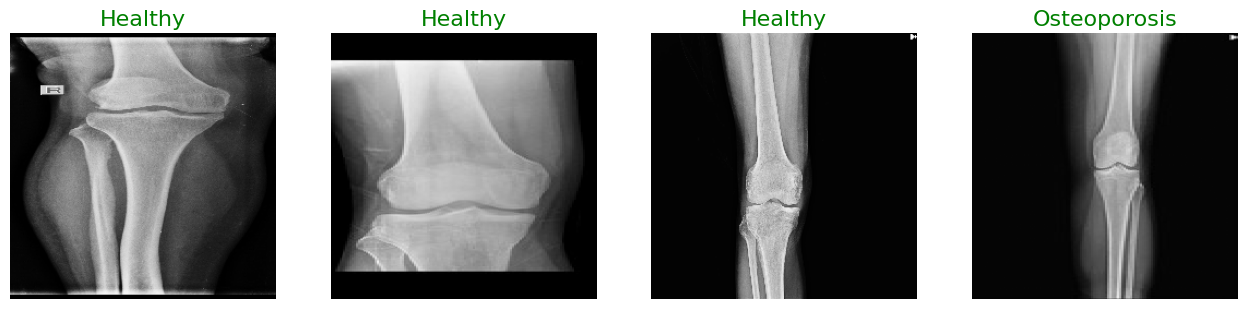

In [ ]:
show_knee_images(train)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,609,474 (59.55 MB)

 Trainable params: 15,603,074 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
130/352 ━━━━━━━━━━━━━━━━━━━━ 5:17 1s/step - accuracy: 0.5242 - loss: 1.7038

In [ ]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 [==============================] - 31s 89ms/step - loss: 0.1074 - accuracy: 0.9630 - val_loss: 0.1957 - val_accuracy: 0.9176


In [ ]:
model.evaluate(test, verbose=1)

132/132 [==============================] - 9s 66ms/step - loss: 0.1625 - accuracy: 0.9337


[0.1625158041715622, 0.9337121248245239]

In [ ]:
history2 = model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 [==============================] - 32s 92ms/step - loss: 0.1114 - accuracy: 0.9623 - val_loss: 0.1618 - val_accuracy: 0.9148


In [ ]:
model.evaluate(test, verbose=1)

132/132 [==============================] - 9s 65ms/step - loss: 0.1304 - accuracy: 0.9318


[0.1304173618555069, 0.9318181872367859]

In [ ]:
model.save("Osteoporosis_Model_binary.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

132/132 [==============================] - 8s 57ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.94      0.91      0.92       233
Osteoporosis       0.93      0.95      0.94       295

    accuracy                           0.93       528
   macro avg       0.93      0.93      0.93       528
weighted avg       0.93      0.93      0.93       528

Accuracy of the Model: 93.2%


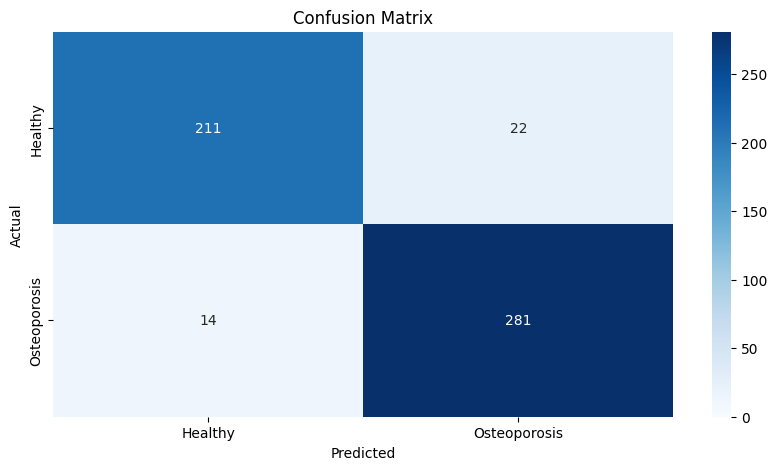

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

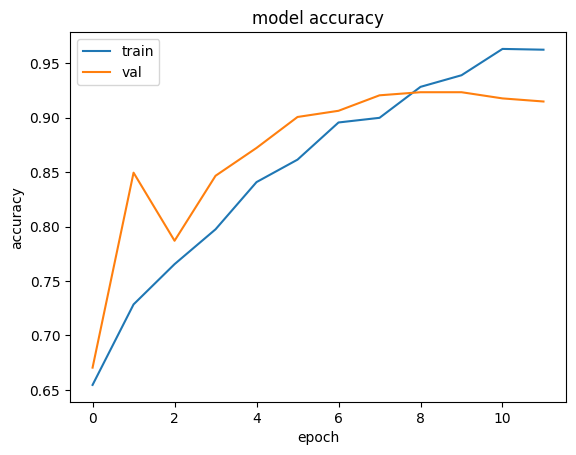

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'] )
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

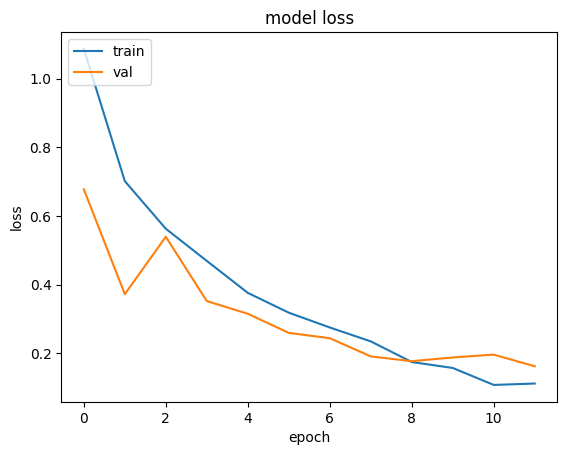

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'] + history2.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**VGG19**

In [ ]:
train_data, remaining_data = train_test_split(knee_osteoporosis_data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1407, 2)
(176, 2)
(176, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_data,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_data,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_data,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1407 validated image filenames belonging to 2 classes.
Found 176 validated image filenames belonging to 2 classes.
Found 176 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
      # Menentukan jumlah maksimal gambar yang akan ditampilkan
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        # Menambahkan judul dengan nama kelas
        index=np.argmax(labels[i]) # mengembalikan indeks dari nilai probabilitas terbesar, yang mewakili kelas yang diprediksi.
        class_name=classes[index] # Mendapatkan nama kelas berdasarkan indeks
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

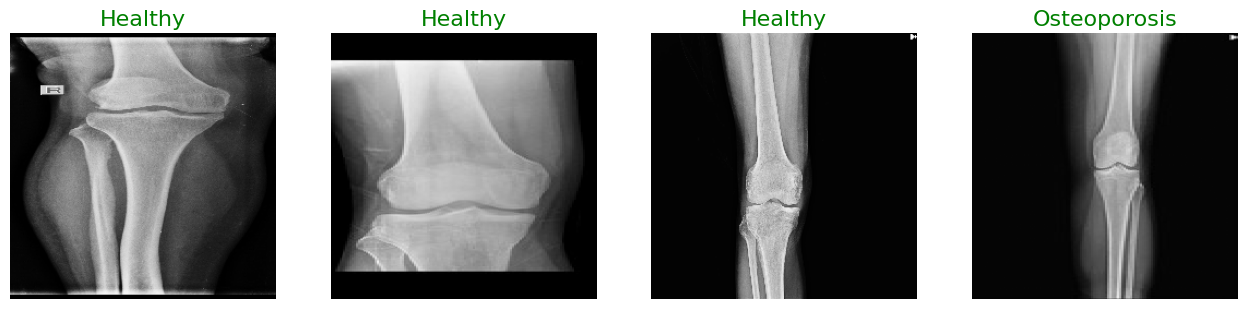

In [ ]:
show_knee_images(train)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from keras.applications import VGG16
import tensorflow as tf

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = vgg16_model.output

# Add your custom layers according to your specified architecture
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.7)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.7)(x)
x = Dense(4096, activation="relu")(x)

output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=vgg16_model.input, outputs=output)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
352/352 [==============================] - 864s 2s/step - loss: 0.6918 - accuracy: 0.5551 - val_loss: 0.6906 - val_accuracy: 0.5455
Epoch 2/5
352/352 [==============================] - 44s 124ms/step - loss: 0.6829 - accuracy: 0.5622 - val_loss: 0.7960 - val_accuracy: 0.5455
Epoch 3/5
352/352 [==============================] - 47s 132ms/step - loss: 0.6343 - accuracy: 0.6055 - val_loss: 0.6347 - val_accuracy: 0.7557
Epoch 4/5
352/352 [==============================] - 45s 127ms/step - loss: 0.5498 - accuracy: 0.7704 - val_loss: 0.5365 - val_accuracy: 0.7784
Epoch 5/5
352/352 [==============================] - 45s 129ms/step - loss: 0.4870 - accuracy: 0.7910 - val_loss: 0.4867 - val_accuracy: 0.7898


In [ ]:
history1 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
352/352 [==============================] - 53s 149ms/step - loss: 0.4522 - accuracy: 0.8117 - val_loss: 0.4001 - val_accuracy: 0.8466
Epoch 2/5
352/352 [==============================] - 45s 126ms/step - loss: 0.4288 - accuracy: 0.8252 - val_loss: 0.4060 - val_accuracy: 0.8182
Epoch 3/5
352/352 [==============================] - 45s 129ms/step - loss: 0.3729 - accuracy: 0.8571 - val_loss: 0.4074 - val_accuracy: 0.8295
Epoch 4/5
352/352 [==============================] - 44s 125ms/step - loss: 0.3317 - accuracy: 0.8749 - val_loss: 0.3250 - val_accuracy: 0.8750
Epoch 5/5
352/352 [==============================] - 48s 136ms/step - loss: 0.2877 - accuracy: 0.8884 - val_loss: 0.3847 - val_accuracy: 0.8466


In [ ]:
model.evaluate(test, verbose=1)

132/132 [==============================] - 10s 77ms/step - loss: 0.1360 - accuracy: 0.9432


[0.1360384225845337, 0.9431818127632141]

In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 73s 2s/step - loss: 0.3861 - accuracy: 0.8523


[0.38606855273246765, 0.8522727489471436]

In [ ]:
history3 = model.fit(train, epochs=2, validation_data=val, verbose=1)

Epoch 1/2
352/352 [==============================] - 48s 137ms/step - loss: 0.2397 - accuracy: 0.9147 - val_loss: 0.2731 - val_accuracy: 0.8977
Epoch 2/2
352/352 [==============================] - 44s 125ms/step - loss: 0.2014 - accuracy: 0.9289 - val_loss: 0.2956 - val_accuracy: 0.8750


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 4s 90ms/step - loss: 0.2617 - accuracy: 0.8920


[0.26167652010917664, 0.8920454382896423]

In [ ]:
history4 = model.fit(train,epochs=4,validation_data=val,verbose=1)

Epoch 1/4
352/352 [==============================] - 46s 130ms/step - loss: 0.1852 - accuracy: 0.9303 - val_loss: 0.3253 - val_accuracy: 0.8636
Epoch 2/4
352/352 [==============================] - 46s 130ms/step - loss: 0.1638 - accuracy: 0.9417 - val_loss: 0.2827 - val_accuracy: 0.8920
Epoch 3/4
352/352 [==============================] - 44s 125ms/step - loss: 0.1467 - accuracy: 0.9410 - val_loss: 0.2414 - val_accuracy: 0.9148
Epoch 4/4
352/352 [==============================] - 44s 126ms/step - loss: 0.1388 - accuracy: 0.9481 - val_loss: 0.1647 - val_accuracy: 0.9205


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 4s 85ms/step - loss: 0.1496 - accuracy: 0.9375


[0.14959166944026947, 0.9375]

In [ ]:
history5 = model.fit(train,epochs=2,validation_data=val,verbose=1)

Epoch 1/2
352/352 [==============================] - 46s 131ms/step - loss: 0.1139 - accuracy: 0.9552 - val_loss: 0.2307 - val_accuracy: 0.9034
Epoch 2/2
352/352 [==============================] - 44s 126ms/step - loss: 0.1199 - accuracy: 0.9545 - val_loss: 0.2154 - val_accuracy: 0.9148


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 4s 93ms/step - loss: 0.1402 - accuracy: 0.9205


[0.14018993079662323, 0.9204545617103577]

In [ ]:
history6 = model.fit(train,epochs=1,validation_data=val,verbose=1)

352/352 [==============================] - 46s 130ms/step - loss: 0.0901 - accuracy: 0.9630 - val_loss: 0.1635 - val_accuracy: 0.9261


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 4s 90ms/step - loss: 0.1339 - accuracy: 0.9489


[0.1339380294084549, 0.9488636255264282]

In [ ]:
history7 = model.fit(train,epochs=1,validation_data=val,verbose=1)

352/352 [==============================] - 49s 139ms/step - loss: 0.0889 - accuracy: 0.9623 - val_loss: 0.1576 - val_accuracy: 0.9148


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 3s 62ms/step - loss: 0.1372 - accuracy: 0.9432


[0.1372024118900299, 0.9431818127632141]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

44/44 [==============================] - 4s 73ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

y_test = test_data.labels # set y_test to the expected output
print(classification_report(y_test, pred2, digits=5))
print("Accuracy of the Model: {:.5f}".format(accuracy_score(y_test, pred2)))
precision = precision_score(y_test, pred2, average='weighted')
print("Precision of the Model: {:.5f}".format(precision))
recall = recall_score(y_test, pred2, average='weighted')
print("Recall Score of the Model: {:.5f}".format(recall))
f1 = f1_score(y_test, pred2, average='weighted')
print("f1 Score of the Model: {:.5f}".format(f1))

              precision    recall  f1-score   support

     Healthy    0.91111   0.97619   0.94253        84
Osteoporosis    0.97674   0.91304   0.94382        92

    accuracy                        0.94318       176
   macro avg    0.94393   0.94462   0.94317       176
weighted avg    0.94542   0.94318   0.94320       176

Accuracy of the Model: 0.94318
Precision of the Model: 0.94542
Recall Score of the Model: 0.94318
f1 Score of the Model: 0.94320


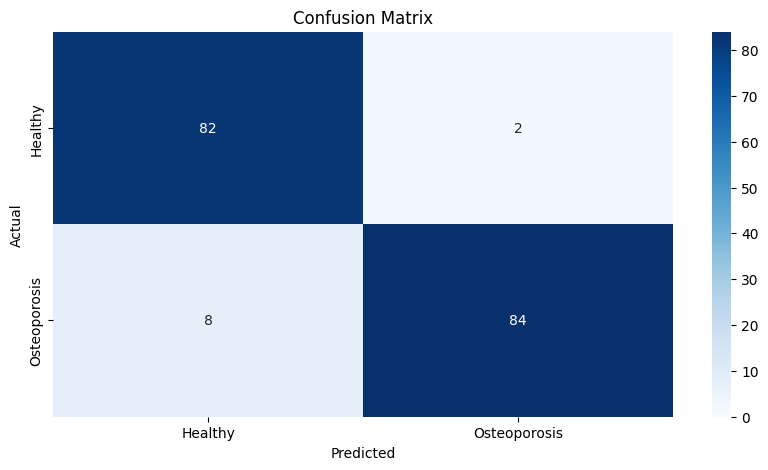

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

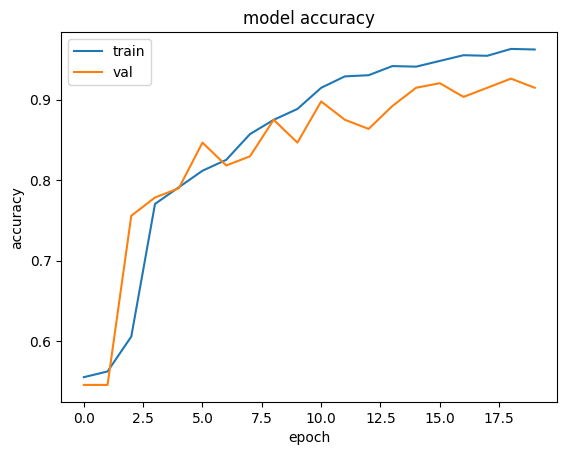

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history3.history['accuracy']+ history4.history['accuracy']+ history5.history['accuracy']+ history6.history['accuracy']+ history7.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history3.history['val_accuracy'] + history4.history['val_accuracy']+ history5.history['val_accuracy']+ history6.history['val_accuracy']+ history7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

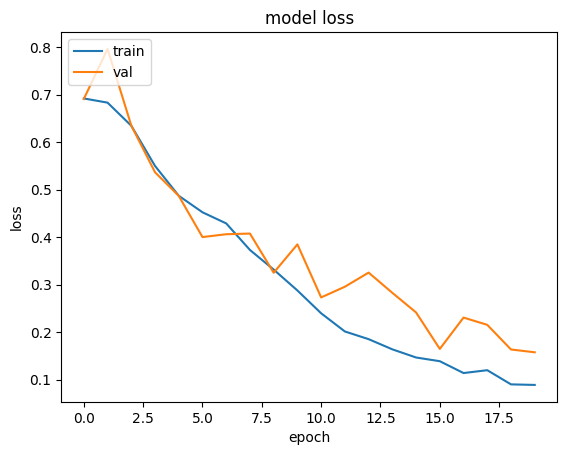

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'] + history3.history['loss']+ history4.history['loss']+ history5.history['loss']+ history6.history['loss']+ history7.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss']+ history5.history['val_loss']+ history6.history['val_loss']+ history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**ResNet**

In [ ]:
train_data, remaining_data = train_test_split(knee_osteoporosis_data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1407, 2)
(176, 2)
(176, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_data,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_data,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_data,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1407 validated image filenames belonging to 2 classes.
Found 176 validated image filenames belonging to 2 classes.
Found 176 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
      # Menentukan jumlah maksimal gambar yang akan ditampilkan
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        # Menambahkan judul dengan nama kelas
        index=np.argmax(labels[i]) # mengembalikan indeks dari nilai probabilitas terbesar, yang mewakili kelas yang diprediksi.
        class_name=classes[index] # Mendapatkan nama kelas berdasarkan indeks
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

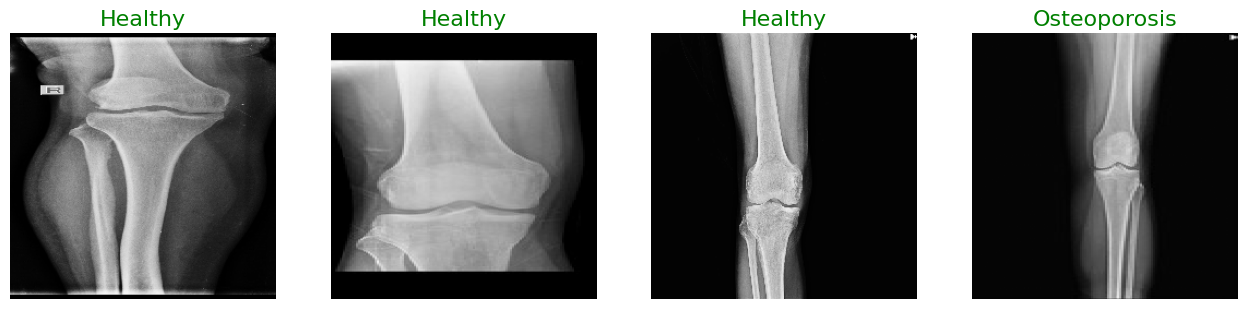

In [ ]:
show_knee_images(train)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = resnet50_model.output

# Add your custom layers according to your specified architecture
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)

output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=resnet50_model.input, outputs=output)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
history = model.fit(train, epochs=15, validation_data=val, verbose=1)

Epoch 1/15
352/352 [==============================] - 881s 2s/step - loss: 0.6922 - accuracy: 0.5537 - val_loss: 0.6904 - val_accuracy: 0.5455
Epoch 2/15
352/352 [==============================] - 44s 125ms/step - loss: 0.5616 - accuracy: 0.6994 - val_loss: 0.6056 - val_accuracy: 0.6761
Epoch 3/15
352/352 [==============================] - 44s 125ms/step - loss: 0.2453 - accuracy: 0.9154 - val_loss: 0.3661 - val_accuracy: 0.8580
Epoch 4/15
352/352 [==============================] - 44s 125ms/step - loss: 0.1336 - accuracy: 0.9566 - val_loss: 0.3562 - val_accuracy: 0.8352
Epoch 5/15
352/352 [==============================] - 47s 132ms/step - loss: 0.0622 - accuracy: 0.9829 - val_loss: 0.4038 - val_accuracy: 0.8920
Epoch 6/15
352/352 [==============================] - 45s 126ms/step - loss: 0.0359 - accuracy: 0.9929 - val_loss: 0.4985 - val_accuracy: 0.8750
Epoch 7/15
352/352 [==============================] - 46s 132ms/step - loss: 0.0362 - accuracy: 0.9929 - val_loss: 0.4907 - val_accu

In [ ]:
history1 = model.fit(train, epochs=15, validation_data=val, verbose=1)

Epoch 1/15
352/352 [==============================] - 45s 129ms/step - loss: 6.5718e-05 - accuracy: 1.0000 - val_loss: 0.8740 - val_accuracy: 0.8977
Epoch 2/15
352/352 [==============================] - 46s 131ms/step - loss: 3.8096e-05 - accuracy: 1.0000 - val_loss: 0.9335 - val_accuracy: 0.8920
Epoch 3/15
352/352 [==============================] - 44s 126ms/step - loss: 2.4600e-05 - accuracy: 1.0000 - val_loss: 0.9713 - val_accuracy: 0.8807
Epoch 4/15
352/352 [==============================] - 44s 125ms/step - loss: 1.4340e-05 - accuracy: 1.0000 - val_loss: 1.0307 - val_accuracy: 0.8807
Epoch 5/15
352/352 [==============================] - 44s 125ms/step - loss: 1.0647e-05 - accuracy: 1.0000 - val_loss: 1.0921 - val_accuracy: 0.9034
Epoch 6/15
352/352 [==============================] - 45s 126ms/step - loss: 6.1139e-06 - accuracy: 1.0000 - val_loss: 1.1215 - val_accuracy: 0.8920
Epoch 7/15
352/352 [==============================] - 44s 124ms/step - loss: 5.5313e-06 - accuracy: 1.0000

In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 61s 1s/step - loss: 0.7624 - accuracy: 0.9489


[0.7624315619468689, 0.9488636255264282]

In [ ]:
history2 = model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 [==============================] - 48s 136ms/step - loss: 5.7864e-07 - accuracy: 1.0000 - val_loss: 1.5383 - val_accuracy: 0.8864


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 5s 117ms/step - loss: 0.7726 - accuracy: 0.9489


[0.7726213932037354, 0.9488636255264282]

In [ ]:
history3 = model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 [==============================] - 48s 136ms/step - loss: 3.4102e-07 - accuracy: 1.0000 - val_loss: 1.6311 - val_accuracy: 0.8920


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 5s 114ms/step - loss: 0.8291 - accuracy: 0.9489


[0.8290848135948181, 0.9488636255264282]

In [ ]:
model.save("Osteoporosis_Model_binary.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

44/44 [==============================] - 5s 74ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

y_test = test_data.labels # set y_test to the expected output
print(classification_report(y_test, pred2, digits=5))
print("Accuracy of the Model: {:.5f}".format(accuracy_score(y_test, pred2)))
precision = precision_score(y_test, pred2, average='weighted')
print("Precision of the Model: {:.5f}".format(precision))
recall = recall_score(y_test, pred2, average='weighted')
print("Recall Score of the Model: {:.5f}".format(recall))
f1 = f1_score(y_test, pred2, average='weighted')
print("f1 Score of the Model: {:.5f}".format(f1))

              precision    recall  f1-score   support

     Healthy    0.93103   0.96429   0.94737        84
Osteoporosis    0.96629   0.93478   0.95028        92

    accuracy                        0.94886       176
   macro avg    0.94866   0.94953   0.94882       176
weighted avg    0.94946   0.94886   0.94889       176

Accuracy of the Model: 0.94886
Precision of the Model: 0.94946
Recall Score of the Model: 0.94886
f1 Score of the Model: 0.94889


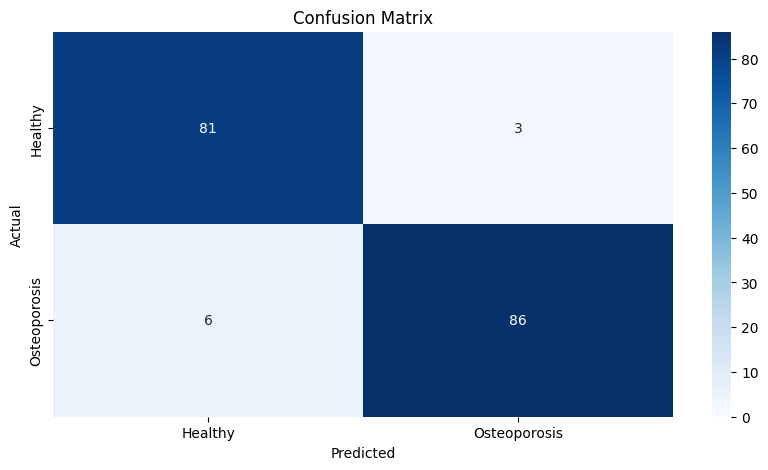

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

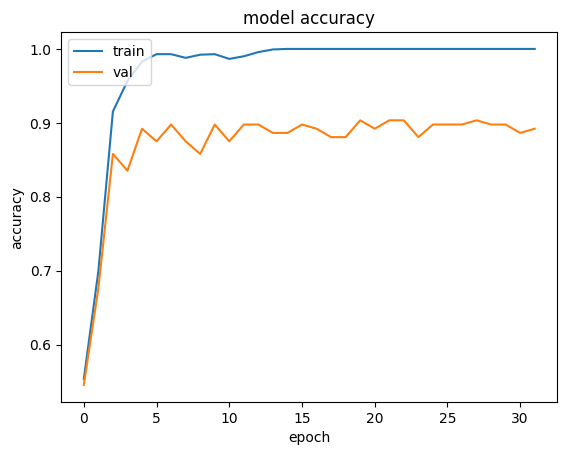

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

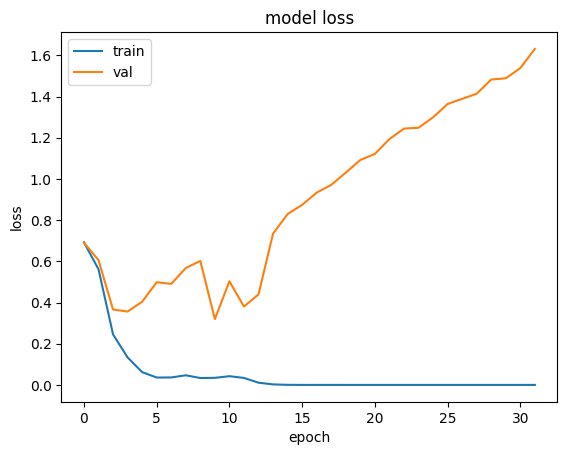

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'] + history2.history['loss'] + history3.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**code completed)))**

**DenseNet Architecture**

In [ ]:
!pip install --upgrade tensorflow keras


In [ ]:
# Corrected ImageDataGenerator setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

# Updated data generators with correct target size
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Correct target size
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Correct target size
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Correct target size
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)


Found 1407 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 352 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121

# Load DenseNet121 with pre-trained weights, without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Debugging shape after the base model
x = base_model.output
x_shape = x.shape

# Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)
gap_shape = x.shape

# Dense Layers
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output Layer
output = layers.Dense(2, activation='softmax')(x)

# Construct the model
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Model summary
model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))

(x_shape, gap_shape, "\n".join(model_summary))


ModuleNotFoundError: No module named 'keras.src.engine.base_layer_v1'

In [ ]:
pip install --upgrade tensorflow


In [ ]:
tf.keras.backend.clear_session()


In [ ]:
history = model.fit(
    train,
    epochs=15,
    validation_data=val,
    verbose=1
)


NameError: name 'model' is not defined

In [ ]:
model.evaluate(test, verbose=1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8326 - loss: 0.3599


[0.34011828899383545, 0.8371211886405945]

In [ ]:
history1 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.8216 - loss: 0.3914 - val_accuracy: 0.8182 - val_loss: 0.4142
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step - accuracy: 0.8287 - loss: 0.3805 - val_accuracy: 0.8352 - val_loss: 0.3569
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.8524 - loss: 0.3527 - val_accuracy: 0.8409 - val_loss: 0.3561
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.8000 - loss: 0.3959 - val_accuracy: 0.8409 - val_loss: 0.3426
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.8477 - loss: 0.3368 - val_accuracy: 0.8466 - val_loss: 0.3340


In [ ]:
model.evaluate(test, verbose=1)

NameError: name 'model' is not defined

In [ ]:
history2 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
352/352 [==============================] - 31s 87ms/step - loss: 0.3675 - accuracy: 0.8351 - val_loss: 0.3621 - val_accuracy: 0.8295
Epoch 2/5
352/352 [==============================] - 30s 86ms/step - loss: 0.3624 - accuracy: 0.8216 - val_loss: 0.3564 - val_accuracy: 0.8438
Epoch 3/5
352/352 [==============================] - 31s 87ms/step - loss: 0.3849 - accuracy: 0.8301 - val_loss: 0.2985 - val_accuracy: 0.8750
Epoch 4/5
352/352 [==============================] - 32s 91ms/step - loss: 0.3513 - accuracy: 0.8351 - val_loss: 0.3165 - val_accuracy: 0.8494
Epoch 5/5
352/352 [==============================] - 30s 86ms/step - loss: 0.3626 - accuracy: 0.8244 - val_loss: 0.3413 - val_accuracy: 0.8466


In [ ]:
model.evaluate(test, verbose=1)

NameError: name 'model' is not defined

**ALEXNET**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Define the model
alexnet_model = Sequential([
    # Conv Layer 1
    Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(244, 244, 3)),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 2
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 3
    Conv2D(512, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten Layer
    Flatten(),

    # Dense Layers
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Adjust the number of units based on your number of classes
])



In [ ]:
# Compile the mo del
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history_alexnet = alexnet_model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
208/352 ━━━━━━━━━━━━━━━━━━━━ 1:42:30 43s/step - accuracy: 0.5790 - loss: 270.2953

In [ ]:
alexnet_model.evaluate(test, verbose=1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.7529 - loss: 2.3517


[2.069950819015503, 0.7727272510528564]

In [ ]:
history_alexnet1 = alexnet_model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 133s 376ms/step - accuracy: 0.6952 - loss: 4.3107 - val_accuracy: 0.7074 - val_loss: 3.1664
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 131s 370ms/step - accuracy: 0.7008 - loss: 3.4523 - val_accuracy: 0.7500 - val_loss: 1.5384
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 143s 372ms/step - accuracy: 0.6942 - loss: 1.8889 - val_accuracy: 0.8068 - val_loss: 0.8996
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 131s 370ms/step - accuracy: 0.7245 - loss: 1.5805 - val_accuracy: 0.7102 - val_loss: 0.7667
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 131s 371ms/step - accuracy: 0.7063 - loss: 1.5973 - val_accuracy: 0.7557 - val_loss: 2.5613


In [ ]:
alexnet_model.evaluate(test, verbose=1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.7658 - loss: 2.9529


[2.1262621879577637, 0.7632575631141663]

In [ ]:
history_alexnet2 = alexnet_model.fit(train, epochs=2, validation_data=val, verbose=1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 132s 373ms/step - accuracy: 0.7044 - loss: 0.9141 - val_accuracy: 0.7415 - val_loss: 0.5335
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 131s 371ms/step - accuracy: 0.7244 - loss: 0.9810 - val_accuracy: 0.7898 - val_loss: 0.5313
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 132s 373ms/step - accuracy: 0.7334 - loss: 0.8038 - val_accuracy: 0.7415 - val_loss: 0.5434
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 131s 369ms/step - accuracy: 0.6821 - loss: 1.0475 - val_accuracy: 0.5369 - val_loss: 2.1732
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 130s 367ms/step - accuracy: 0.5590 - loss: 1.8460 - val_accuracy: 0.5256 - val_loss: 0.9193


In [ ]:
alexnet_model.evaluate(test, verbose=1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.5393 - loss: 0.9233


[0.8390665650367737, 0.5511363744735718]

In [ ]:
history_alexnet3 = alexnet_model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 ━━━━━━━━━━━━━━━━━━━━ 129s 365ms/step - accuracy: 0.5737 - loss: 0.9395 - val_accuracy: 0.5341 - val_loss: 0.6919


In [ ]:
alexnet_model.evaluate(test, verbose=1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.5471 - loss: 0.6888


[0.6851450800895691, 0.5587121248245239]

In [ ]:
history_alexnet3 = alexnet_model.fit(train, epochs=2, validation_data=val, verbose=1)

Epoch 1/2
352/352 ━━━━━━━━━━━━━━━━━━━━ 130s 363ms/step - accuracy: 0.5533 - loss: 0.7965 - val_accuracy: 0.5341 - val_loss: 0.6903
Epoch 2/2
352/352 ━━━━━━━━━━━━━━━━━━━━ 141s 363ms/step - accuracy: 0.5705 - loss: 0.8603 - val_accuracy: 0.5341 - val_loss: 0.7905


In [ ]:
alexnet_model.evaluate(test, verbose=1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.5471 - loss: 0.7652


[0.7695974111557007, 0.5587121248245239]

In [ ]:
y_test = test.labels

In [ ]:
y_test = test.labels

# Step 2: Make predictions using the trained model
alexnet_pred = alexnet_model.predict(test)
alexnet_pred = np.argmax(alexnet_pred, axis=1)

NameError: name 'test' is not defined

In [ ]:
history_alexnet = alexnet_model.fit(train, epochs=5, validation_data=val, verbose=1)
alexnet_eval = alexnet_model.evaluate(test, verbose=1)
alexnet_pred = alexnet_model.predict(test)
alexnet_pred = np.argmax(alexnet_pred, axis=1)
alexnet_report = classification_report(test, alexnet_pred, target_names=class_labels, digits=5)
print(alexnet_report)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 131s 371ms/step - accuracy: 0.7491 - loss: 1.0673 - val_accuracy: 0.6705 - val_loss: 0.8904
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 130s 369ms/step - accuracy: 0.7500 - loss: 2.0164 - val_accuracy: 0.5994 - val_loss: 1.2315
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 130s 368ms/step - accuracy: 0.7718 - loss: 1.2699 - val_accuracy: 0.7273 - val_loss: 0.8184
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 130s 368ms/step - accuracy: 0.7132 - loss: 1.3762 - val_accuracy: 0.7188 - val_loss: 0.8640
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 129s 366ms/step - accuracy: 0.6655 - loss: 0.8235 - val_accuracy: 0.6307 - val_loss: 0.7144
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.6378 - loss: 0.7037
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step


ValueError: Found input variables with inconsistent numbers of samples: [132, 528]

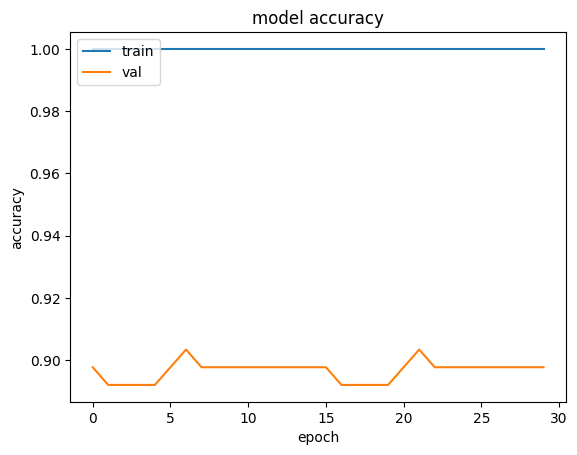

In [ ]:
plt.plot(history.history['accuracy']+history.history['accuracy'])
plt.plot(history.history['val_accuracy']+history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


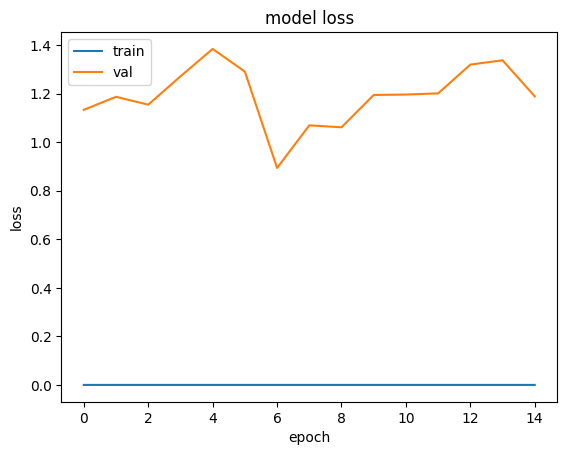

In [ ]:
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'] )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
